In [1]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
import numpy as np


# Load the data
# Load the data with ';' delimiter
measures = pd.read_csv('measures.csv', delimiter=';')
to_predict = pd.read_csv('to_predict.csv', delimiter=';')

# Convert comma decimal separator to dot and convert columns to appropriate types
measures = measures.map(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
measures = measures.astype({col: float for col in measures.columns if col not in ['subject', 'activity']})
measures['subject'] = measures['subject'].astype(float)

to_predict = to_predict.map(lambda x: x.replace(',', '.') if isinstance(x, str) else x)
to_predict = to_predict.astype({col: float for col in measures.columns if col not in ['subject', 'activity']})

# Define the subjects for training and test sets
training_subjects =      [1, 3, 5, 6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26]
test_subjects = [27, 28, 29, 30]

# Split the measures dataset into training and test sets
training_set = measures[measures['subject'].isin(training_subjects)]
test_set = measures[measures['subject'].isin(test_subjects)]

# Ensure there's no overlap
assert not training_set['subject'].isin(test_subjects).any(), "Training and test sets overlap!"

# Define features and labels
X_train = training_set.drop(columns=['subject', 'activity'])
y_train = training_set['activity']

X_test = test_set.drop(columns=['subject', 'activity'])
y_test = test_set['activity']




Skaling the data doesnt work

führt zu schlecteren ergebnissen ohne feature selection und mit FS zu keinen ergebnissen.

In [4]:
from sklearn.preprocessing import MinMaxScaler

# Scaling the data
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


Outlier Detection --> schlechtere ergebnisse


Training set: 528 outliers removed out of 5280 samples
Test set: 135 outliers removed out of 1451 samples
Prediction set: 462 outliers removed out of 2947 samples

In [15]:
from sklearn.ensemble import IsolationForest

# Outlier detection using Isolation Forest for the training set
iso_forest = IsolationForest(contamination=0.1, random_state=42)
yhat_train = iso_forest.fit_predict(X_train)

# Select all rows that are not outliers in the training set
mask_train = yhat_train != -1
outliers_train = np.sum(~mask_train)
X_train, y_train = X_train[mask_train], y_train[mask_train]

print(f"Training set: {outliers_train} outliers removed out of {len(yhat_train)} samples")


Training set: 528 outliers removed out of 5280 samples
Test set: 135 outliers removed out of 1451 samples
Prediction set: 462 outliers removed out of 2947 samples


1. Optimal Feature Selection:
Let's try selecting a different number of top features to see if we can find a better subset. We can use methods like Recursive Feature Elimination (RFE) with cross-validation to determine the optimal number of features.

2. Recursive Feature Elimination with Cross-Validation (RFECV):
This method helps find the best number of features by recursively removing the least important features and evaluating the model's performance.

This is for LogReg

In [2]:
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

# Initialize the model
#rf_model = RandomForestClassifier(n_estimators=5, random_state=42)
log_reg = LogisticRegression(max_iter=1000, C=38, dual=False)
#log_reg = DecisionTreeClassifier(max_depth=1000, min_samples_split=2)


print("start")
# Initialize RFECV
rfecv = RFECV(estimator=log_reg, step=1, cv=StratifiedKFold(5), scoring='accuracy')
print("eval")

# Fit RFECV
rfecv.fit(X_train, y_train)
print("fitted")

# Get the optimal number of features
optimal_num_features = rfecv.n_features_
print("Optimal number of features:", optimal_num_features)

# Get the support and ranking of features
selected_features = X_train.columns[rfecv.support_]
print("Selected features:", selected_features)

# Create new datasets with selected features
X_train_optimal_log_reg = X_train[selected_features]
X_test_optimal_log_reg = X_test[selected_features]



print("modelling")

# Train model using optimal features
#rf_model_optimal = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model_optimal = LogisticRegression(max_iter=10000, C=38, dual=False)
rf_model_optimal.fit(X_train_optimal_log_reg, y_train)
accuracy_optimal = rf_model_optimal.score(X_test_optimal_log_reg, y_test)
print("Test Set Accuracy with Optimal Features:", accuracy_optimal)

# Optimal number of features: 138
# Test Set Accuracy with Optimal Features: 0.9683501683501684
# with LogisticRegression(max_iter=10000, C=38, dual=False)



start
eval
fitted
Optimal number of features: 138
Selected features: Index(['tBodyAcc-std()-X', 'tBodyAcc-std()-Y', 'tBodyAcc-max()-X',
       'tBodyAcc-max()-Z', 'tBodyAcc-min()-X', 'tBodyAcc-min()-Y',
       'tBodyAcc-min()-Z', 'tBodyAcc-iqr()-Z', 'tBodyAcc-entropy()-X',
       'tBodyAcc-entropy()-Y',
       ...
       'fBodyBodyAccJerkMag-std()', 'fBodyBodyAccJerkMag-max()',
       'fBodyBodyAccJerkMag-entropy()', 'fBodyBodyAccJerkMag-skewness()',
       'fBodyBodyGyroMag-min()', 'fBodyBodyGyroMag-meanFreq()',
       'fBodyBodyGyroJerkMag-min()', 'fBodyBodyGyroJerkMag-skewness()',
       'angle(X,gravityMean)', 'angle(Y,gravityMean)'],
      dtype='object', length=138)
modelling
Test Set Accuracy with Optimal Features: 0.9683501683501684


This is for SVM

In [3]:
# Initialize classifiers with chosen hyperparameters
svm = SVC(C=40, gamma=0.055, kernel='rbf', probability=True)
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
dt = DecisionTreeClassifier(max_depth=1000, min_samples_split=2)
rf = RandomForestClassifier(max_depth=100, n_estimators=1000)
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3)
nb = GaussianNB()
ada = AdaBoostClassifier(n_estimators=100, learning_rate=1, algorithm="SAMME")
mlp = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', solver='lbfgs', alpha=0.002, learning_rate='adaptive', max_iter=2500)
xgb = XGBClassifier(n_estimators=500, learning_rate=0.2, max_depth=5, subsample=0.8, colsample_bytree=0.8, use_label_encoder=False, eval_metric='mlogloss')

In [27]:
# Define the ensemble of classifiers
ensemble = VotingClassifier(estimators=[
    #('log_reg', log_reg),
    ('svm', svm),
    #('knn', knn),
    #('dt', dt),
    #('rf', rf),
    #('gb', gb),
    #('nb', nb),
    #('ada', ada),
    #('mlp', mlp),
    #('xgb', xgb)
], voting='soft')  # Use 'soft' for probability-based voting

# Fit the ensemble model
ensemble.fit(X_train, y_train)

print("-->", ensemble.score(X_test, y_test))


# Predict on the test set
y_pred = ensemble.predict(X_test)

# Calculate accuracy and classification error
accuracy = accuracy_score(y_test, y_pred)
classification_error = 1 - accuracy

# Print the results
print("\nEnsemble Model:")
print("Test Set Accuracy:", accuracy)
# lr svm Test Set Accuracy: 0.9717171717171718
#nur svm --> 0.9676767676767677
#nur svm mit feeature selection --> 0.9703703703703703
#svm mit outlier --> 0.9680851063829787

--> 0.9676767676767677

Ensemble Model:
Test Set Accuracy: 0.9676767676767677


In [4]:
ensemble = VotingClassifier(estimators=[
    #('log_reg', log_reg),
    ('svm', svm),
    #('xgb', xgb),
    #('mlp', mlp),
], voting='soft')  # Use 'soft' for probability-based voting


svm.fit(X_train_optimal_log_reg, y_train)

#ensemble.fit(X_train_optimal_log_reg, y_train)
print("top features -->", svm.score(X_test_optimal_log_reg, y_test))

# top features --> 0.9730639730639731 mit verbesserung der logReg features
# new highest solo SVM top features --> 0.9757575757575757
#mit outleir --> 0.9680851063829787

top features --> 0.9757575757575757



Confusion Matrix:
 [[293   0   0   0   0   0]
 [  0 240  24   0   0   0]
 [  0  12 271   0   0   0]
 [  0   0   0 229   0   0]
 [  0   0   0   0 200   0]
 [  0   0   0   0   0 216]]

Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       293
           SITTING       0.95      0.91      0.93       264
          STANDING       0.92      0.96      0.94       283
           WALKING       1.00      1.00      1.00       229
WALKING_DOWNSTAIRS       1.00      1.00      1.00       200
  WALKING_UPSTAIRS       1.00      1.00      1.00       216

          accuracy                           0.98      1485
         macro avg       0.98      0.98      0.98      1485
      weighted avg       0.98      0.98      0.98      1485

Test Set Error: 0.024242424242424288


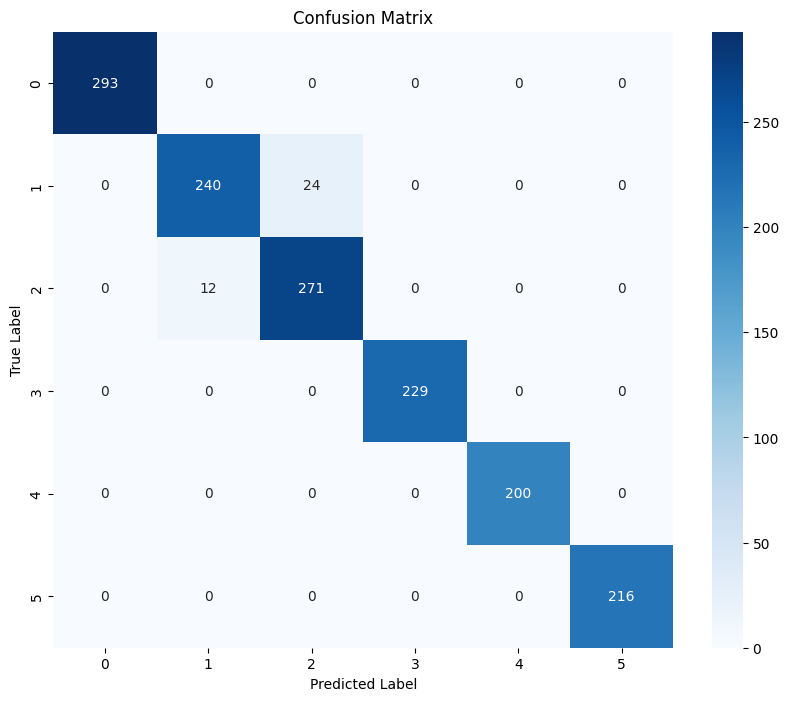

Problematic Classes (less than 50% correct): []


In [34]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt


y_pred = ensemble.predict(X_test_optimal_log_reg)

# Confusion matrix and test error
conf_matrix = confusion_matrix(y_test, y_pred)
test_error = 1 - accuracy_score(y_test, y_pred)

print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Test Set Error:", test_error)

# Visualizing the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Identifying problematic classes
problematic_classes = np.where(conf_matrix.diagonal() < 0.5 * np.sum(conf_matrix, axis=1))[0]
print("Problematic Classes (less than 50% correct):", problematic_classes)

Weighted SVM Test Set Accuracy: 0.9757575757575757

Weighted SVM Confusion Matrix:
 [[293   0   0   0   0   0]
 [  0 240  24   0   0   0]
 [  0  12 271   0   0   0]
 [  0   0   0 229   0   0]
 [  0   0   0   0 200   0]
 [  0   0   0   0   0 216]]

Weighted SVM Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       293
           SITTING       0.95      0.91      0.93       264
          STANDING       0.92      0.96      0.94       283
           WALKING       1.00      1.00      1.00       229
WALKING_DOWNSTAIRS       1.00      1.00      1.00       200
  WALKING_UPSTAIRS       1.00      1.00      1.00       216

          accuracy                           0.98      1485
         macro avg       0.98      0.98      0.98      1485
      weighted avg       0.98      0.98      0.98      1485



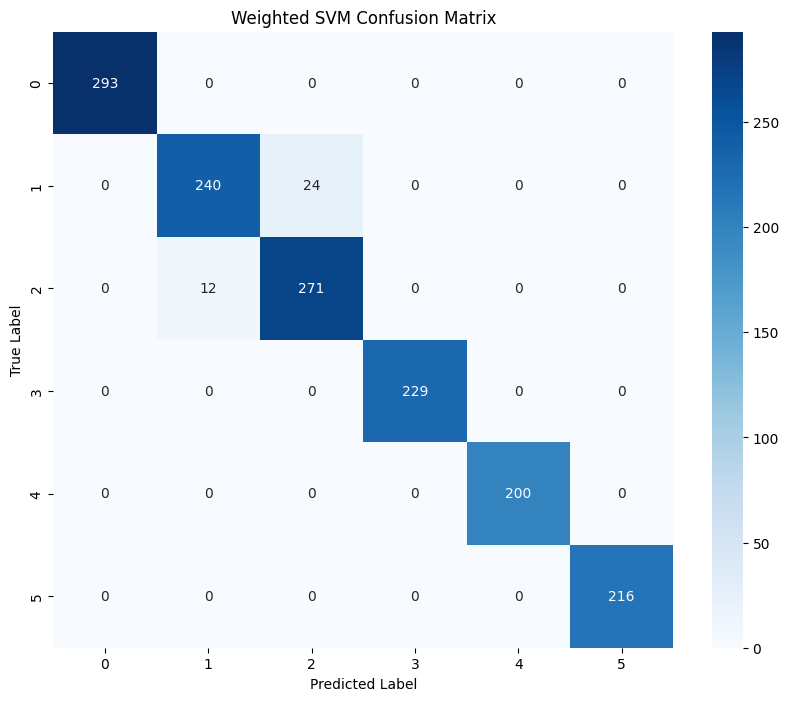

In [37]:
from sklearn.utils.class_weight import compute_class_weight

# Calculate class weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Initialize the SVM classifier with class weights
weighted_svm = SVC(C=40, gamma=0.055, kernel='rbf', probability=True, class_weight=class_weight_dict)

# Fit the model with the training data
weighted_svm.fit(X_train_optimal_log_reg, y_train)

# Predict on the test set
y_pred_weighted = weighted_svm.predict(X_test_optimal_log_reg)

# Calculate accuracy and confusion matrix
accuracy_weighted = accuracy_score(y_test, y_pred_weighted)
conf_matrix_weighted = confusion_matrix(y_test, y_pred_weighted)

# Print the results
print("Weighted SVM Test Set Accuracy:", accuracy_weighted)
print("\nWeighted SVM Confusion Matrix:\n", conf_matrix_weighted)
print("\nWeighted SVM Classification Report:\n", classification_report(y_test, y_pred_weighted))

# Visualizing the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_weighted, annot=True, fmt='d', cmap='Blues')
plt.title('Weighted SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


SMOTE SVM Test Set Accuracy: 0.9764309764309764

SMOTE SVM Confusion Matrix:
 [[293   0   0   0   0   0]
 [  0 240  24   0   0   0]
 [  0  11 272   0   0   0]
 [  0   0   0 229   0   0]
 [  0   0   0   0 200   0]
 [  0   0   0   0   0 216]]

SMOTE SVM Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       293
           SITTING       0.96      0.91      0.93       264
          STANDING       0.92      0.96      0.94       283
           WALKING       1.00      1.00      1.00       229
WALKING_DOWNSTAIRS       1.00      1.00      1.00       200
  WALKING_UPSTAIRS       1.00      1.00      1.00       216

          accuracy                           0.98      1485
         macro avg       0.98      0.98      0.98      1485
      weighted avg       0.98      0.98      0.98      1485



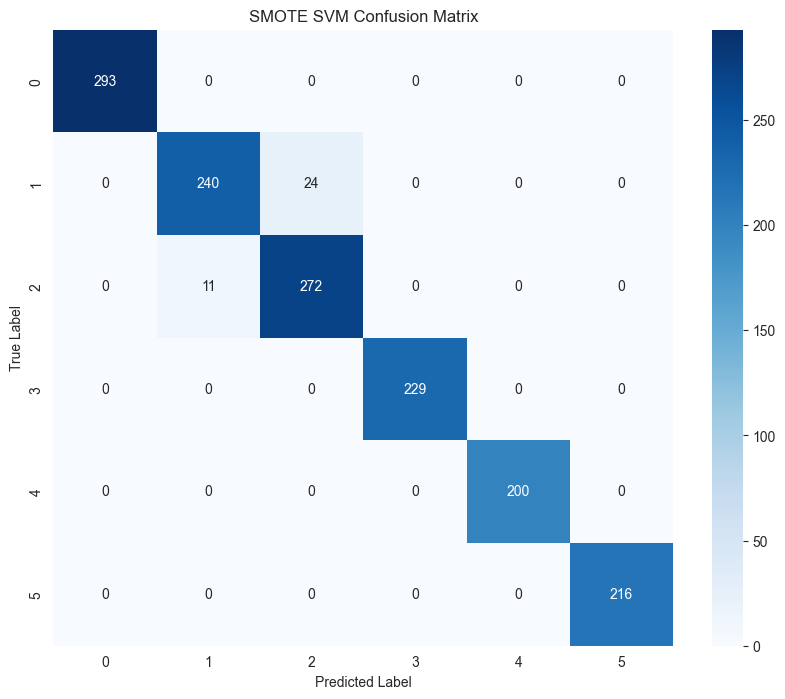

In [5]:
from imblearn.over_sampling import SMOTE
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# Apply SMOTE to the training data
smote = SMOTE(random_state=6)
X_train_smote, y_train_smote = smote.fit_resample(X_train_optimal_log_reg, y_train)

# Initialize the SVM classifier
svm_smote = SVC(C=40, gamma=0.055, kernel='rbf', probability=True)

# Train the classifier on the oversampled data
svm_smote.fit(X_train_smote, y_train_smote)

# Predict on the test set
y_pred_smote = svm_smote.predict(X_test_optimal_log_reg)

# Calculate accuracy and confusion matrix
accuracy_smote = accuracy_score(y_test, y_pred_smote)
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)

# Print the results
print("SMOTE SVM Test Set Accuracy:", accuracy_smote)
print("\nSMOTE SVM Confusion Matrix:\n", conf_matrix_smote)
print("\nSMOTE SVM Classification Report:\n", classification_report(y_test, y_pred_smote))

# Visualizing the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_smote, annot=True, fmt='d', cmap='Blues')
plt.title('SMOTE SVM Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


Stacked Model Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       293
           SITTING       0.92      0.86      0.89       264
          STANDING       0.87      0.93      0.90       283
           WALKING       1.00      0.99      1.00       229
WALKING_DOWNSTAIRS       1.00      0.99      0.99       200
  WALKING_UPSTAIRS       0.98      1.00      0.99       216

          accuracy                           0.96      1485
         macro avg       0.96      0.96      0.96      1485
      weighted avg       0.96      0.96      0.96      1485


SMOTE SVM Test Set Accuracy: 0.9764309764309764

SMOTE SVM Confusion Matrix:
 [[293   0   0   0   0   0]
 [  0 240  24   0   0   0]
 [  0  11 272   0   0   0]
 [  0   0   0 229   0   0]
 [  0   0   0   0 200   0]
 [  0   0   0   0   0 216]]

Stacked Model Test Set Accuracy: 0.9737373737373738

Stacked Model Confusion Matrix:
 [[293   0   0   0   0   0]
 [  0 234  30   0   0   0]
 [  0   9 274   0   0   0]
 [  0   0   0 229   0   0]
 [  0   0   0   0 200   0]
 [  0   0   0   0   0 216]]

Stacked Model Classification Report:
                     precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       293
           SITTING       0.96      0.89      0.92       264
          STANDING       0.90      0.97      0.93       283
           WALKING       1.00      1.00      1.00       229
WALKING_DOWNSTAIRS       1.00      1.00      1.00       200
  WALKING_UPSTAIRS       1.00      1.00      1.00       216

          accuracy                           0.97      1485
         macro avg       0.98      0.98      0.98      1485
      weighted avg       0.97      0.97      0.97      1485



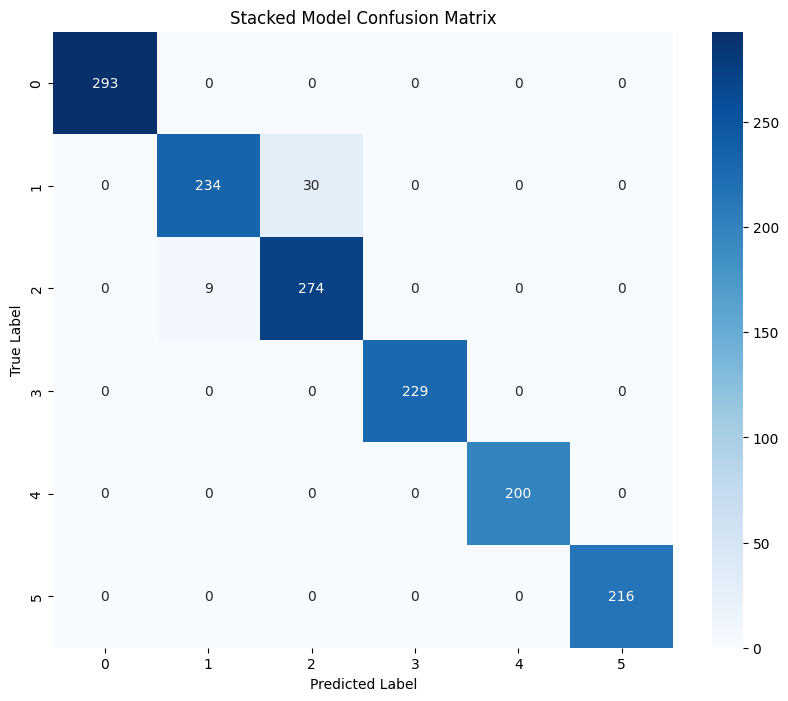